In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import AutoModel , AutoImageProcessor , AutoTokenizer 
from datasets import load_dataset , Dataset
from PIL import Image
from datasets import Image as dImage
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.cuda.empty_cache()

2024-05-16 19:08:05.179442: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-16 19:08:05.182296: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-16 19:08:05.233389: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-16 19:08:05.236804: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 19:08:05.926290: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
def training_img_address(input):
    IMAGE_DIR = "./train2014_3d"
    input["image_id"] = f"{IMAGE_DIR}/{input['image_id']}"
    return input

In [3]:
SAMPLE_SET = "10k"

df = pd.read_pickle(f"vqa_v2_sampled_{SAMPLE_SET}.pkl")
SAMPLES = len(df)

print("Number of samples are : " , SAMPLES)

df.head()

Number of samples are :  13000


,question,question_type,question_id,image_id,answer_type,label
0,Are all the men using headphones?,are,448439000,COCO_train2014_000000448439.jpg,yes/no,"{'ids': ['no'], 'weights': [1.0]}"
1,Are any of these ties tied?,are,21674004,COCO_train2014_000000021674.jpg,yes/no,"{'ids': ['yes', 'no'], 'weights': [0.79, 0.21]}"
2,Are all of these adults?,are,532439000,COCO_train2014_000000532439.jpg,yes/no,"{'ids': ['yes', 'no'], 'weights': [0.8, 0.2]}"
3,Are both doors open on the icebox?,are,341218001,COCO_train2014_000000341218.jpg,yes/no,"{'ids': ['yes'], 'weights': [1.0]}"
4,Are those mountains in the distance?,are,23249002,COCO_train2014_000000023249.jpg,yes/no,"{'ids': ['yes', 'no'], 'weights': [0.95, 0.05]}"


In [6]:
dataset = Dataset.from_pandas(df)
dataset = dataset.map(training_img_address)
dataset = dataset.cast_column("image_id", dImage())

dataset

Map: 100%|██████████| 13000/13000 [00:01<00:00, 12469.46 examples/s]


Dataset({
    features: ['question', 'question_type', 'question_id', 'image_id', 'answer_type', 'label'],
    num_rows: 13000
})

In [7]:
dataset[0]["image_id"].size

(640, 478)

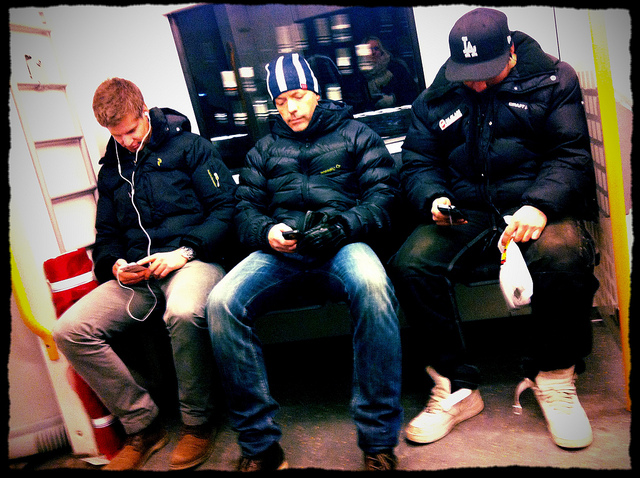

In [8]:
dataset[0]["image_id"]

In [9]:
# X_img = np.array([np.array(Image.open(i)) for i in dataset["image_id"]])
# X_text = np.array(dataset["question"])
# X_img.shape , X_text.shape

Creating Labels

In [10]:
import itertools

labels = [item['ids'] for item in dataset['label']]
flattened_labels = list(itertools.chain(*labels))
unique_labels = list(set(flattened_labels))

label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for label, idx in label2id.items()} 

In [11]:
label2id

{'it is forest': 0,
 'vandals': 1,
 'volleyball': 2,
 'keyboard, mouse, booklet': 3,
 '2 of them': 4,
 'torch': 5,
 'toddler urinal': 6,
 'empire': 7,
 'skyscraper': 8,
 'snowboarding gear': 9,
 'winter': 10,
 'because of science': 11,
 'a&w': 12,
 'pony': 13,
 'jeans and top': 14,
 'hat': 15,
 'wall behind woman': 16,
 'logo colors': 17,
 'she is standing': 18,
 'one on far left': 19,
 'portrait orientation': 20,
 "doesn't say": 21,
 'taking selfie': 22,
 'powdered sugar': 23,
 'because they cannot get in': 24,
 '6.47': 25,
 'horse obstacle course': 26,
 'playing frisbee football': 27,
 '70 107': 28,
 'reading to kids': 29,
 '3 different directions': 30,
 'city block': 31,
 'dough': 32,
 'no train': 33,
 'dining': 34,
 'bacon and eggs': 35,
 "banana's": 36,
 'mitsubishi': 37,
 'left and right': 38,
 '1:25': 39,
 '8 inches': 40,
 'state pl': 41,
 'nametag': 42,
 'few': 43,
 '4:55': 44,
 '2.5 feet': 45,
 'see': 46,
 'woman is on left holding wii remotes': 47,
 'just ate': 48,
 'westmins

In [15]:
# def replace_ids(inputs):
#     '''Converting everything to one-hot-encoding'''
#     h = [0 for i in id2label]
#     for i in range(len(inputs["label"]["ids"])):
#         t = inputs["label"]["ids"][i]
#         w = inputs["label"]["weights"][i]
#         if w > 0.5: w = 1
#         else: w = 0.3
#         # print(t , w)
#         # print(label2id.get(t , 0))
#         h[label2id.get(t , 0)] = w
#     inputs["label"] = h
#     inputs["image_id"] = inputs["image_id"].resize((640 , 480))
#     return inputs


# flat_dataset = dataset.map(replace_ids)
# flat_dataset.save_to_disk(f"./vqa_v2_sampled_{SAMPLE_SET}.hf")


flat_dataset = Dataset.load_from_disk(f"./vqa_v2_sampled_{SAMPLE_SET}.hf")

NUM_CLASSES = len(id2label)
print("Number of Classes : " , NUM_CLASSES)

Number of Classes :  12251


Testing BERT and ViT

In [16]:
DEVICE = "cuda"

vit_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
# model = AutoModel.from_pretrained("google/vit-base-patch16-224").to(DEVICE)
vit_model = AutoModel.from_pretrained("google/vit-base-patch16-224")

/home1/nikhil/miniconda3/envs/python38/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
from transformers import BertTokenizer , BertModel

bert_processor = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

/home1/nikhil/miniconda3/envs/python38/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [13]:
# ip = vit_processor(X_img , return_tensors="pt")
# # outp = vit_model(**ip)
# outp = vit_model(ip["pixel_values"])
# outp.keys()

In [30]:
class CustomVITModel(nn.Module):
    def __init__(self):
        super(CustomVITModel, self).__init__()
        self.vit = vit_model
        self.bert = bert_model
        ### New layers:
        self.linear1 = nn.Linear(768 * 2, 256)
        self.relu = nn.ReLU()
        self.dpout = nn.Dropout(0.25)
        self.linear2 = nn.Linear(256, 64) ## 3 is the number of classes in this example
        self.linear3 = nn.Linear(64, NUM_CLASSES) ## 3 is the number of classes in this example
        self.sigmoid = nn.Softmax()

    def forward(self, pixel_values , input_ids , attention_mask):
        vit_outp = self.vit(pixel_values)
        vit_last_hidden_state, vit_pooled_output = vit_outp.last_hidden_state , vit_outp.pooler_output
        
        bert_outp = self.bert(input_ids , attention_mask=attention_mask)
        bert_last_hidden_state, bert_pooled_output = bert_outp.last_hidden_state , bert_outp.pooler_output
        
        # last_hidden_state = last_hidden_state.cuda()
        # pooled_output = pooled_output.cuda()

        # sequence_output has the following shape: (batch_size, sequence_length, 768)
        
        combined_input = torch.cat([vit_pooled_output,bert_pooled_output] , axis=1)
        
        # linear1_output = self.linear1(last_hidden_state[:,0,:].view(-1,768)) ## extract the 1st token's embeddings
        out = self.linear1(combined_input)
        out = self.relu(out)
        # out = nn.functional.batch_norm(out)
        out = self.dpout(out)

        out = self.linear2(out)
        out = self.relu(out)
        # out = nn.functional.batch_norm(out)
        out = self.dpout(out)
        
        out = self.linear3(out)
        
        pred = out
        # pred = self.sigmoid(linear2_output)

        return pred

# tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-italian-xxl-cased") 
model_custom = CustomVITModel() # You can pass the parameters if required to have more flexible model
# model_custom.to("cuda") ## can be gpu
criterion = nn.CrossEntropyLoss() ## If required define your own criterion
# criterion = nn.BCELoss() ## If required define your own criterion
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_custom.parameters()) , lr=3e-5)

In [31]:
from torchinfo import summary

summary(model_custom)

Layer (type:depth-idx)                                  Param #
CustomVITModel                                          --
├─ViTModel: 1-1                                         --
│    └─ViTEmbeddings: 2-1                               152,064
│    │    └─ViTPatchEmbeddings: 3-1                     590,592
│    │    └─Dropout: 3-2                                --
│    └─ViTEncoder: 2-2                                  --
│    │    └─ModuleList: 3-3                             85,054,464
│    └─LayerNorm: 2-3                                   1,536
│    └─ViTPooler: 2-4                                   --
│    │    └─Linear: 3-4                                 590,592
│    │    └─Tanh: 3-5                                   --
├─BertModel: 1-2                                        --
│    └─BertEmbeddings: 2-5                              --
│    │    └─Embedding: 3-6                              23,440,896
│    │    └─Embedding: 3-7                              393,216
│    │    └─

In [20]:
flat_dataset.set_format("torch")

In [21]:
test_split = 0.3
test_size = int(SAMPLES * test_split)

# small_train_dataset = flat_dataset["train"].shuffle(seed=42).select(range(1000))
# small_eval_dataset = flat_dataset["test"].shuffle(seed=42).select(range(1000))

small_train_dataset = flat_dataset.select(range(SAMPLES - test_size))
small_eval_dataset = flat_dataset.select(range(SAMPLES - test_size , SAMPLES))

len(small_train_dataset) , len(small_eval_dataset)

(9100, 3900)

In [22]:
from torch.utils.data import DataLoader

batch_size = 16

train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=batch_size)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=batch_size)

In [28]:
for batch in train_dataloader:
    print(batch["label"].shape)
    break

torch.Size([16, 12251])


In [33]:
from tqdm.auto import tqdm


EPOCHS = 50

num_training_steps = EPOCHS * len(train_dataloader)
progress_bar = tqdm(range(num_training_steps))

print("Starting Training")
for epoch in range(EPOCHS):
    epoch_loss = 0
    pred_sum = 0
    running_loss = 0
    for batch in train_dataloader:

        ques = batch["question"]
        images = batch["image_id"]
        targets = batch["label"]

        # data_img = dataset["image_id"][i:i + batch_size]
        # data_text = dataset["question"][i:i + batch_size]
        # # targets = np.array([[0],[1]])
        # targets = Y[i : i + batch_size]
        # # data = data.cuda()
        # # targets = targets.cuda()

        
        optimizer.zero_grad()   
        # encoding = tokenizer.batch_encode_plus(data, return_tensors='pt', padding=True, truncation=True,max_length=50, add_special_tokens = True)
        pixel_values = vit_processor(images , return_tensors="pt")["pixel_values"]
        bertop = bert_processor(ques, padding=True, truncation=True, return_tensors="pt")
        input_ids , attention_mask = bertop["input_ids"] , bertop["attention_mask"]
        outputs = model_custom(pixel_values , input_ids , attention_mask)

        loss = criterion(outputs, targets)
        # print(loss)
        loss.backward()
        optimizer.step()

        y_truth = torch.argmax(targets, dim=1)
        y = torch.argmax(outputs , dim=1)
        correct_predictions = sum(y_truth == y).item()

        pred_sum += correct_predictions
        epoch_loss += outputs.shape[0] * loss.item()
        running_loss += loss.item()
        # if i % 2000 == 1999:    # print every 2000 mini-batches
        #     print('[%d, %5d] loss: %.3f' %
        #           (epoch + 1, i + 1, running_loss / 2000))
        #     running_loss = 0.0
        progress_bar.update(1)
    train_acc = pred_sum / SAMPLES
    print(f"Epoch {epoch+1}/{EPOCHS} - loss : {round(epoch_loss / SAMPLES , 4)} - acc : {train_acc:.4f}")

  0%|          | 0/28450 [00:23<?, ?it/s]


Starting Training
Epoch 1/50 - loss : 5.3071 - acc : 0.1878


KeyboardInterrupt: 

Question :  this model does not work lmao?
Answer :  yes


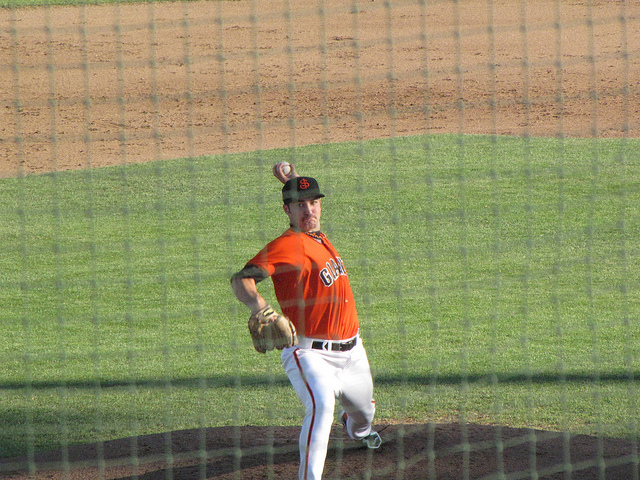

In [29]:
question = "this model does not work lmao?"

im = X_img[0]

ip1 = vit_processor(im , return_tensors="pt")["pixel_values"]
ip2 = bert_processor(question , padding=True, truncation=True, return_tensors="pt")
logits = model_custom(ip1 , ip2["input_ids"] , ip2["attention_mask"])
pred_probab = nn.Softmax()(logits)
ans = torch.argmax(pred_probab).item()

im = Image.fromarray(im , 'RGB')

print("Question : " , question)
print("Answer : " , id2label[ans])

im

### Testing PyTorch Training

In [31]:
class ClassificationHead(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ClassificationHead, self).__init__()
        # self.fc1 = nn.Linear(input_size, 128)
        # self.fc2 = nn.Linear(128, 64)
        # self.fc3 = nn.Linear(64, num_classes)
        # self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
        )
        
    
    def forward(self, x):
        # x = self.fc1(x)
        # x = self.relu(x)
        # x = self.fc2(x)
        # x = self.relu(x)
        # x = self.fc3(x)
        # # x = self.sigmoid(x)
        # return x
        
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Define your number of classes
num_classes = NUM_CLASSES  # Number of classes in your classification task

classification_head = ClassificationHead(vit_model.config.hidden_size, num_classes)


loss_fn = nn.CrossEntropyLoss() ## If required define your own criterion
# optimizer = torch.optim.Adam(vit_model.parameters(), lr=0.0001)
optimizer = torch.optim.Adam(classification_head.parameters(), lr=0.0001)

# Create the classification head

EPOCHS = 2
batch_size = 2
Y = torch.tensor(flat_dataset["label"])

print("Training:")
# Training Loop
running_loss = 0.0
batch = 0
for epoch in range(EPOCHS):
    classification_head.train()
    for i in range(0 , len(X_img) , batch_size):
        batch += 1
        inputs = X_img[i:i+batch_size]
        labels = Y[i:i+batch_size]
        labels=labels.to(torch.float)
        
        ip = vit_processor(inputs , return_tensors="pt")

        # Forward pass
        outputs = vit_model(**ip).last_hidden_state[:, 0, :]
        logits = classification_head(outputs)
        
        # Calculate loss
        loss = loss_fn(logits, labels)
        running_loss += loss.item()
        
        # print(f"EPOCH : {epoch} | BATCH : {i} | LOSS : {running_loss}")
        # print(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss, current = loss.item(), batch * batch_size + len(inputs)
        print(f"loss: {loss:>7f} ")

# print("Inference:")
# # Inference
# with torch.no_grad():
#     inputs = X
#     ip = processor(inputs , return_tensors="pt")
#     outputs = model(**ip).last_hidden_state[:, 0, :]
#     logits = classification_head(outputs)
#     ans = nn.functional.sigmoid(logits)
#     print(ans)

Training:
loss: 4.144501 
loss: 3.394263 
loss: 2.881017 
loss: 5.493414 
loss: 2.792670 
loss: 4.001240 
loss: 3.337624 
loss: 2.815248 
loss: 5.356466 
loss: 2.645538 


In [26]:
print("Inference:")
# Inference
with torch.no_grad():
    inputs = X_img
    ip = vit_processor(inputs , return_tensors="pt")
    outputs = vit_model(**ip).last_hidden_state[:, 0, :]
    logits = classification_head(outputs)
    logits = nn.Softmax(dim=1)(logits)
    print(logits)

Inference:
tensor([[0.0591, 0.0525, 0.0507, 0.0482, 0.0511, 0.0474, 0.0651, 0.0681, 0.0618,
         0.0517, 0.0544, 0.0456, 0.0711, 0.0489, 0.0517, 0.0619, 0.0478, 0.0628],
        [0.0591, 0.0525, 0.0507, 0.0482, 0.0511, 0.0474, 0.0651, 0.0681, 0.0618,
         0.0517, 0.0544, 0.0456, 0.0711, 0.0489, 0.0517, 0.0619, 0.0478, 0.0628],
        [0.0591, 0.0525, 0.0507, 0.0482, 0.0511, 0.0474, 0.0651, 0.0681, 0.0618,
         0.0517, 0.0544, 0.0456, 0.0711, 0.0489, 0.0517, 0.0619, 0.0478, 0.0628],
        [0.0591, 0.0525, 0.0507, 0.0482, 0.0511, 0.0474, 0.0651, 0.0681, 0.0618,
         0.0517, 0.0544, 0.0456, 0.0711, 0.0489, 0.0517, 0.0619, 0.0478, 0.0628],
        [0.0494, 0.0695, 0.0510, 0.0574, 0.0531, 0.0528, 0.0647, 0.0473, 0.0524,
         0.0598, 0.0624, 0.0550, 0.0618, 0.0528, 0.0587, 0.0551, 0.0496, 0.0472],
        [0.0494, 0.0695, 0.0510, 0.0574, 0.0531, 0.0528, 0.0647, 0.0473, 0.0524,
         0.0598, 0.0624, 0.0550, 0.0618, 0.0528, 0.0587, 0.0551, 0.0496, 0.0472],
        [0.

In [ ]:
Training:
tensor(4.2284, grad_fn=<DivBackward1>)
tensor(3.3829, grad_fn=<DivBackward1>)
tensor(2.9335, grad_fn=<DivBackward1>)
tensor(5.4293, grad_fn=<DivBackward1>)
tensor(2.7480, grad_fn=<DivBackward1>)
tensor(4.1977, grad_fn=<DivBackward1>)
tensor(3.3491, grad_fn=<DivBackward1>)
tensor(2.8715, grad_fn=<DivBackward1>)
tensor(5.2210, grad_fn=<DivBackward1>)
tensor(2.5404, grad_fn=<DivBackward1>)

### TensorFlow

In [61]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")
tokenized_data = tokenizer(dataset["question"], return_tensors="np", padding=True)
# Tokenizer returns a BatchEncoding, but we convert that to a dict for Keras
tokenized_data = dict(tokenized_data)

labels = Y.detach().cpu().numpy()

In [74]:
tokenized_data

{'input_ids': array([[ 101, 1327, 1110, ...,    0,    0,    0],
        [ 101, 1327, 1700, ...,    0,    0,    0],
        [ 101, 1327, 2942, ...,    0,    0,    0],
        ...,
        [ 101, 1731, 1242, ...,    0,    0,    0],
        [ 101, 2181, 1175, ...,    0,    0,    0],
        [ 101, 1731, 1242, ...,    0,    0,    0]]),
 'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]])}

In [72]:
x = tf.keras.Input(shape=(None,))
tokenizer(x, return_tensors="np", padding=True)

ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [82]:
from transformers import TFAutoModelForSequenceClassification , TFAutoModel , TFAutoModelForImageClassification
from tensorflow.keras.optimizers import Adam

# Load and compile our model
# tf_model = tf.keras.models.Sequential(
#     [
#         TFAutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased"),
#         tf.keras.layers.Dense(1 , input_shape=(768,) , activation='sigmoid')
#     ]
# )

# x = tf.keras.Input(shape=)
# tf_model = TFAutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased")

proc = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
tf_model = TFAutoModel.from_pretrained("google/vit-base-patch16-224")(**tf_model)
# tf_model = tf.keras.layers.Dense(1 , input_shape=(768,1) , activation='sigmoid')(tf_model.logits)

# # Lower learning rates are often better for fine-tuning transformers
# tf_model.compile(optimizer=Adam(3e-5))  # No loss argument!

tf_model.fit(X, labels)
# tf_model


/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
All PyTorch model weights were used when initializing TFViTForImageClassification.

All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


ValueError: Exception encountered when calling layer 'patch_embeddings' (type TFViTPatchEmbeddings).

Make sure that the channel dimension of the pixel values match with the one set in the configuration.

Call arguments received by layer 'patch_embeddings' (type TFViTPatchEmbeddings):
  • pixel_values=tf.Tensor(shape=(100, 480, 640, 3), dtype=uint8)
  • interpolate_pos_encoding=None
  • training=False